In [1]:
exec(open('init_notebook.py').read())

current working dirD:\ML\nlp\nlp-practice


In [172]:
import pandas as pd
import numpy as np
import numpy.typing as npt
import nltk
# import seaborn as sns
import tqdm
import os
from nltk.corpus import stopwords
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.metrics import accuracy_score, balanced_accuracy_score

from nltk import word_tokenize
from library.common_preprocess import *
from library.selection import *

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline


import math
import heapq

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'sortedcontainers'

In [132]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Background
Word embeddings extend the idea of co-occurance matrix which captures co-occuring words in a very sparse matrix. Word embeddings reduce the sparse encoding into a very dense vector. There exists other approaches which can compress the co-occurance matrix using Singular Value Decomposition (SVD) such as Latent Semantic Analysis (LSA). 

### There are two different ways to train word2vec: 
1. Continous Bag of Words (CBOW) approach where a set of context words predict the center word
2. Continuous Skip-Gram (or Skipgram) model where one context word is used to predict words at different positions before and after it.

In [3]:
## Data
dataDir = os.path.join(projectFolder, "data")
dataDir

'D:/ML/nlp/nlp-practice\\data'

In [4]:
corpus = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

# we won't lemmatize the words. but we will strip puntuations and make words lower


wordToIndex = buildWordToIndex (
    word_tokenize, 
    [corpus], 
    maxSize = 5000,
    # stopWords=stopwords.words('english'),
    stopWords=None,
    lowercase=True,
    ignorePunkt=True
)

paddingWord = "0_0"
wordToIndex[paddingWord] = len(wordToIndex) # our pad
idxToWord = {v: k for k, v in wordToIndex.items()}


corpusWords = lowerUnPunkt(word_tokenize(corpus))

*** top 10 words out of 60 words***
algorithms 4
to 4
machine 3
learning 3
is 3
of 3
as 3
a 3
the 2
computer 2


In [170]:
Vector = npt.NDArray
def cosineSimilarity(v1: Vector, v2: Vector) -> float:
    # returns similariy in cos theta
    # a @ b = |a||b|cos(theta)
    return (v1 @ v2) / (torch.linalg.norm(v1, ord=2) * torch.linalg.norm(v2, ord=2))

def mostSimilarWords(wordToEmbedding: Dict[Word, Vector], k: int) -> List[Tuple[Word, Word]]:
    # On^2 search
    similarTupes = []
    words = list(wordToEmbedding.keys())
    for w1Idx in range(len(words)-1):
        w1 = words[w1Idx]
        for w2Idx in range(w1Idx+1, len(words)):
            w2 = words[w2Idx]
            sim = cosineSimilarity(wordToEmbedding[w1], wordToEmbedding[w2])
            similarTupes.append((sim, w1, w2))
    return heapq.nlarges
    

#### CBOW
Steps
1. n = 3. for each word we will take 3 words before and 3 words after. If not enough words, we will use a 0-padding.
2. we will pass the context words through the same hidden layer (same weights) and average the outputs to get the context. Then we will use a softmax layer to predict the word
3. loss = - sum(y_i * log(y_hat_i)) / batch_size

Embeddings: embeddings are just the weights. W1[0] for the first word because the 0th index is True

In [78]:
def createCBOWs(corpusWords: List[Word], windowSize: int, paddingWord: Word):
    cbows = []
    extent = windowSize // 2
    for i, target in enumerate(corpusWords):
        left = max(0, i - extent)
        right = min(len(corpusWords), i + extent+1)
        context = corpusWords[left:i] + corpusWords[i+1: right]
        if len(context) < windowSize:
            for i in range(windowSize - len(context)):
                context.append(paddingWord)
        
        cbows.append((context, target))
    return cbows

class CBOWDataset(Dataset):
    def __init__(self, cbows: List[Tuple[List[Word], Word]], wordToIndex: Dict[Word, Token], paddingWord: Word):
        self.wordToIndex = wordToIndex
        self.cbows = cbows
        self.paddingWord = paddingWord

    def __len__(self) -> int:
        return len(self.cbows)

    def __getitem__(self, idx: Index) -> Tuple[npt.NDArray, int]:
        # we sum the one hots and divide by the hots?
        context, target = self.cbows[idx]
        x = self.oneHotsAvgRow(context)
        return x, self.wordToIndex[target]
        

    def oneHotColumn(self, word: Word) -> ColumnVector:
        hot = torch.zeros((len(self.wordToIndex), 1))
        hotIdx = self.wordToIndex[word]
        hot[hotIdx] = 1
        return hot
        
    def oneHotsAvgColumn(self, words: List[Word]) -> ColumnVector:
        hot = torch.zeros((len(self.wordToIndex), 1))
        padCount = 0
        for word in words:
            hotIdx = self.wordToIndex[word]
            hot[hotIdx] = 1
            if word == self.paddingWord:
                padCount += 1
        # hot /= (len(words) - padCount) # ?????
        hot /= len(words) # ????? padding
        return hot
        
    def oneHotsAvgRow(self, words: List[Word]) -> RowVector:
        hot = torch.zeros((1, len(self.wordToIndex)))
        padCount = 0
        for word in words:
            hotIdx = self.wordToIndex[word]
            hot[0][hotIdx] = 1
            if word == self.paddingWord:
                padCount += 1
        # hot /= (len(words) - padCount) # ?????
        hot /= len(words) # ????? padding
        return hot
    
        

In [102]:
cbows = createCBOWs(corpusWords, 3, paddingWord)
trainSize = int(len(cbows) * 0.7)
trainDB = CBOWDataset(cbows[0: trainSize], wordToIndex, paddingWord)
testDB = CBOWDataset(cbows[trainSize:], wordToIndex, paddingWord)
trainLoader = DataLoader(trainDB, batch_size = 16, shuffle=True)
testLoader = DataLoader(testDB, batch_size=16, shuffle=True)

In [103]:
cbows[:3]

[(['learning', '0_0', '0_0'], 'machine'),
 (['machine', 'is', '0_0'], 'learning'),
 (['learning', 'the', '0_0'], 'is')]

In [104]:
assert trainDB[0][1] == wordToIndex[cbows[0][1]]
assert testDB[-1][1] == wordToIndex[cbows[-1][1]]
batchX, batchY = next(iter(trainLoader))
batchX.shape, batchY.shape

(torch.Size([16, 1, 62]), torch.Size([16]))

In [142]:
## simple two layer model
ColumnVector = npt.NDArray
Logits = ColumnVector
BatchLogits = npt.NDArray[Logits]

class Model(nn.Module):
    def __init__(self, wordToIndex: Dict[Word, Token], hiddenSize: int):
        super().__init__()
        self.inputSize = len(wordToIndex) # one hot size
        self.hiddenSize = hiddenSize
        self.outputSize = self.inputSize # vocab size
        self.wordToIndex = wordToIndex
        # we create two layers
        self.W1 = nn.Parameter(data=torch.randn((self.inputSize, self.hiddenSize)), requires_grad=True)
        self.W2 = nn.Parameter(data=torch.randn((self.hiddenSize, self.outputSize)), requires_grad=True)


    def forward(self, batch: npt.NDArray[RowVector]) -> BatchLogits: # m, nx -> m, nx # input and output sizes are the same, nx
        batch = batch.squeeze(axis=1) # removing the extra axis
        batch = batch.T # m, nx -> nx, m
        # print(self.W1.T.shape, batch.shape)
        A1 = self.W1.T @ batch # W1.T = n_a, nx, -> n_a, m (n_a is the hidden size, # of neurons)
        A2 = self.W2.T @ A1 # nx, n_a @ n_a, m -> nx, m
        return A2.T
    

In [143]:
n_a = 2
model = Model(wordToIndex, n_a) # we will have a 2 dimensional embedding
model.cuda()

Model()

In [144]:

batchX, batchY = next(iter(trainLoader))
logits = model(batchX.cuda())
# assert logits.shape[0] 
batchX.shape, batchY.shape, logits.shape

(torch.Size([16, 1, 62]), torch.Size([16]), torch.Size([16, 62]))

In [157]:
Optimizer = any
Criterion = Callable[[npt.NDArray, npt.NDArray], float]
Path = str

def train(
        model: nn.Module,
        nEpochs: int,
        trainLoader: DataLoader,
        validationLoader: DataLoader,
        optimizer: Optimizer,
        criterion: Criterion,
        useCuda: bool,
        savePath: Path
    ) -> Tuple[List[float], List[float]]:
    trainLoss = []
    validLoss = []
    minValidationLoss = np.inf

    # we will not use cuda for this one.

    for epoch in tqdm(range(nEpochs)):
        epochTrainLoss = 0.0
        epochValidLoss = 0.0

        ############# Train #############

        model.train()
        for batchIdx, (batchX, batchY) in enumerate(trainLoader):
            #### forward ####
            if useCuda:
                batchX, batchY = batchX.cuda(), batchY.cuda()
            logits = model(batchX)
            loss = criterion(logits, batchY)
            epochTrainLoss += loss.item() / len(batchX)

            #### backward ####
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        trainLoss.append(epochTrainLoss)

        ########### Vlidation ###############
        model.eval()
        with torch.inference_mode():
            for batchIdx, (batchX, batchY) in enumerate(validationLoader):
                
                #### forward #####
                if useCuda:
                    batchX, batchY = batchX.cuda(), batchY.cuda()
                logits = model(batchX)
                loss = criterion(logits, batchY)
                epochValidLoss += loss.item() / len(batchX)
                

        validLoss.append(epochValidLoss)

        
        display.clear_output(wait=True)
        plt.plot(trainLoss, label="train loss")
        plt.plot(validLoss, label="test loss")
        if epoch == 0:
            plt.legend()
        display.display(plt.gcf())
        
    return trainLoss, validLoss
        
    pass

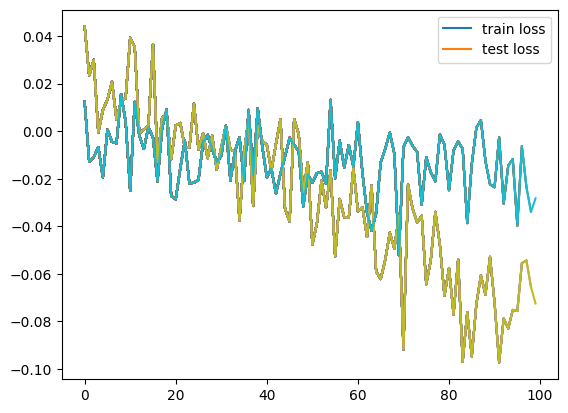

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.82it/s]


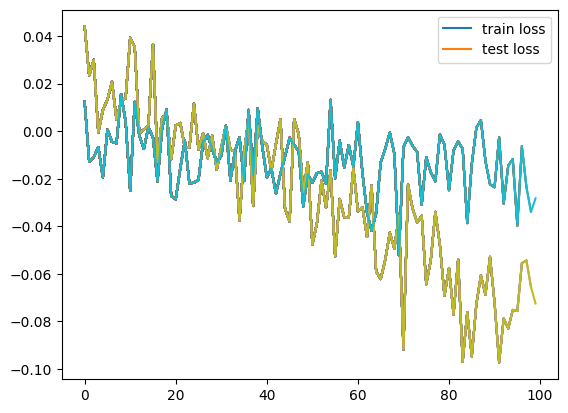

In [161]:
n_a = 2
model = Model(wordToIndex, n_a) # we will have a 2 dimensional embedding
model.cuda()

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
trainLoss, testLoss = train(
    model,
    nEpochs=100,
    trainLoader = trainLoader,
    validationLoader = testLoader,
    optimizer = optimizer,
    criterion = criterion,
    useCuda = True,
    savePath = None)


In [171]:
# The embeddings
# Word Vectors
params = list(model.parameters())
wordVectors = params[0].detach().cpu()
indexedWords = [None] * len(wordToIndex)
for word, idx in wordToIndex.items():
    indexedWords[idx] = word

wordToEmbedding = {word: em for word, em in zip(indexedWords, wordVectors)}
# wordToEmbedding
mostSimilars = mostSimilarWords(wordToEmbedding, 5)
mostSimilars

NameError: name 'SortedList' is not defined

### Skipgram